<a href="https://colab.research.google.com/github/HakujouRyu/DS-Unit-2-Regression-Classification/blob/master/module2/assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

# Set up

In [220]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module2')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Assignment

### Peek

In [223]:
df.shape

(48817, 34)

In [224]:
df.head()
#Lets look at where we'll get the date

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Feature Engineering

#### Neighborhood

In [225]:
len(df['display_address'].unique())
#8.6k different adress labels for 48.8k observations, maybe that's a bit excessive. But I guess we could try later.
#But I don't know if a linear regressions would be the best fit for that idea. Let's see.

8675

In [226]:
pd.get_dummies(df['display_address'])

,East 10th Street and East 11th Street,Washington Street,,Allen street,"Hell's Kitchen, Midtown West","Hell's Kitchen, Midtown West","Hell's Kitchen, Midtown West",11th Street,17th Street,1st Ave.,1st ave,236th Street,2nd Ave.,2nd Street,2nd ave,30th Ave.,30th Avenue,32nd St.,330 east 30th street,38th St.,42nd Road,485 AMSTERDAM AVENUE,506 east 11,5th Avenue,67th Avenue,7th Avenue,88th street,9 ave,9th Street,Amsterdam Ave.,Avenue B,Avenue C,BRAND NEW SS ATTRACTIVE PRIME LOCATED,Bainbridge Street,Bennett Ave,Broadway,Broadway Terrace,Broome St.,Center Boulevard,Central Park,...,w 69,w 83 st,w 89th street,w 9,wall st,wall st.,wall st.,walls st.,washington heights,waverly pl.,waverly place and christopher street,waverly street and charles street,west 152nd street,west 168th St,west 21st street,west 29 street & 8 ave,west 33rd st & 8th ave,west 43 street,west 48 street and then avenue,west 4th street,west 50s,west 50s & 6th avenue - NO FEE,west 51st street,west 52nd st,west 54 st & 8 ave,west 55 street & 6 ave,west 60s,"west 73rd street, Upper west side","west 98th street, Upper west side","west 9th street, Greenwich village",west Houston,west st,west st.,west village,williamsburg,williamsburg,williamsburg NO FEE,williamsburg - NO FEE,williamsburg Northside NO FEE,▇_▶SEE TODAY*330 East 117th St
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [227]:
#Wait a minute....
df['display_address'].value_counts()

Broadway                                     435
East 34th Street                             355
Second Avenue                                349
Wall Street                                  330
West 37th Street                             287
West Street                                  257
First Avenue                                 244
Gold Street                                  241
York Avenue                                  228
Washington Street                            227
John Street                                  214
Water Street                                 214
East 39th Street                             198
East 89th Street                             195
West 54th Street                             193
Lexington Avenue                             189
West 42nd Street                             184
Christopher Street                           180
Columbus Avenue                              177
W 37 St.                                     176
Third Avenue        

In [0]:
#That could definitely be cleaned up a lot. Let's look at something else. 

#### Intrest level

In [229]:
df.interest_level.value_counts()

low       33946
medium    11181
high       3690
Name: interest_level, dtype: int64

In [0]:
#Not that many of those.
df = pd.merge(df, pd.get_dummies(df['interest_level']),left_index=True, right_index=True)

#### Pets allowed

In [0]:
df['pets_allowed'] = (df['cats_allowed'] == 1) & (df['dogs_allowed'] == 1).astype(int)

In [0]:
#I don't understand why the typecasting is being ignored

In [0]:
df['pets_allowed'] = df['pets_allowed'].astype(int)

In [234]:
df.head()
#Better

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,high,low,medium,pets_allowed
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Date Time and split

In [0]:
df['created'] = pd.to_datetime(df['created'])
#Lets cast as datetime

In [236]:
df['created'].dt.year.unique()
#any other years?

array([2016])

In [0]:
train = df[df['created'].dt.month.isin([4,5])]
test = df[df['created'].dt.month == 6]
# Create test/train based on months 

### Linear Regression Model With Only The Engineered Features


#### Import and Fit

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt


In [0]:
model = LinearRegression()

In [0]:
features = ['pets_allowed', 'low','medium','high']

In [0]:
X_train = train[features]
X_test = test[features]

In [0]:
y_train = train['price']
y_test = test['price']

In [275]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Mean Baseline

In [244]:
print('Mean Baseline')
guess = y_train.mean()

# Train Error
y_pred = [guess] * len(y_train)
mae = metrics.mean_absolute_error(y_train, y_pred)
RSME = np.sqrt(metrics.mean_squared_error(y_train,y_pred))
print(f'Train MAE: ${mae:.2f}')
print(f'Train RSME: ${RSME:.2f}')
# Test Error
y_pred = [guess] * len(y_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
RSME = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print(f'Test MAE: ${mae:.2f}')
print(f'Test RSME: ${RSME:.2f}')


Mean Baseline
Train MAE: $1201.88
Train RSME: $1762.11
Test MAE: $1197.71
Test RSME: $1763.00


#### Predictions

In [0]:
y_pred_train = model.predict(X_train)

In [0]:
y_pred = model.predict(X_test)

#### Eval

In [264]:
print('Only enginerred features')

# Train Error
mae = metrics.mean_absolute_error(y_train, y_pred_train)
RSME = np.sqrt(metrics.mean_squared_error(y_train,y_pred_train))
r2 = metrics.r2_score(y_train, y_pred_train)
print(f'Train MAE: ${mae:.2f}')
print(f'Train RSME: ${RSME:.2f}')
print(f'Train R\u00b2: {r2}')
# Test Error
mae = metrics.mean_absolute_error(y_test, y_pred)
RSME = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2 = metrics.r2_score(y_test, y_pred)
print(f'Test MAE: ${mae:.2f}')
print(f'Test RSME: ${RSME:.2f}')
print(f'Train R\u00b2: {r2}')
#Coefs and Intercept
print(f'Intercept: {model.intercept_}')
print(f'Coefficients:  {dict(zip(features, model.coef_))}')

Only enginerred features
Train MAE: $1175.49
Train RSME: $1723.57
Train R²: 0.043264829401606475
Test MAE: $1171.74
Test RSME: $1722.28
Train R²: 0.045613260583608706
Intercept: -2455154207863023.0
Coefficients:  {'pets_allowed': 173.14554550935782, 'low': 2455154207866744.0, 'medium': 2455154207866130.5, 'high': 2455154207865683.5}


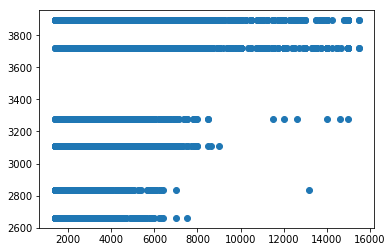

In [276]:
plt.scatter(y_test,y_pred)

### Model with bedrooms and above

In [0]:
features.append('bedrooms')
features.append('bathrooms')

In [301]:
features

['pets_allowed', 'low', 'medium', 'high', 'bedrooms', 'bathrooms']

In [0]:
model2 = LinearRegression()

In [0]:
X_train2 = train[features]
X_test2 = test[features]

In [304]:
model2.fit(X_train2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred2 = model2.predict(X_test2)

In [0]:
y_pred_train2 = model2.predict(X_train2)

In [307]:
# Train Error
mae = metrics.mean_absolute_error(y_train, y_pred_train2)
RSME = np.sqrt(metrics.mean_squared_error(y_train,y_pred_train2))
r2 = metrics.r2_score(y_train, y_pred_train2)
print(f'Train MAE: ${mae:.2f}')
print(f'Train RSME: ${RSME:.2f}')
print(f'Train R\u00b2: {r2}')
# Test Error
mae = metrics.mean_absolute_error(y_test, y_pred2)
RSME = np.sqrt(metrics.mean_squared_error(y_test,y_pred2))
r2 = metrics.r2_score(y_test, y_pred2)
print(f'Test MAE: ${mae:.2f}')
print(f'Test RSME: ${RSME:.2f}')
print(f'Train R\u00b2: {r2}')
#Coefs and Intercept
print(f'Intercept: {model2.intercept_}')
print(f'Coefficients:  {dict(zip(features, model2.coef_))}')

Train MAE: $788.62
Train RSME: $1192.10
Train R²: 0.5423198985061437
Test MAE: $789.66
Test RSME: $1174.80
Train R²: 0.5559400079265924
Intercept: 847000095518415.5
Coefficients:  {'pets_allowed': 136.5781859201054, 'low': -847000095517738.9, 'medium': -847000095518281.5, 'high': -847000095518614.2, 'bedrooms': 420.828125, 'bathrooms': 1983.09375}


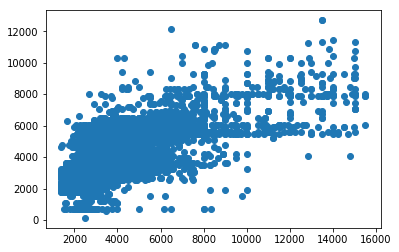

In [308]:
plt.scatter(y_test, y_pred2)